# 0 import data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from collections import Counter

Here you have to give the path to the original imdb data.<br>
Don't forget the slash or backslash at the end.

In [2]:
original_data_path = "/home/user/Documents/studies/master/vu - systeembio master/modules/04 Machine Learning/project/project start data/"

Import all the tables

In [3]:
or_movies = pd.read_csv(original_data_path+'IMDb movies.csv', delimiter=",", low_memory=False)
or_names = pd.read_csv(original_data_path+'IMDb names.csv', delimiter=",", low_memory=False)
or_ratings = pd.read_csv(original_data_path+'IMDb ratings.csv', delimiter=",", low_memory=False)
or_title_principles = pd.read_csv(original_data_path+'IMDb title_principals.csv', delimiter=",", low_memory=False)

# 1 clean the data

## 1.1 look at dimensions of data

In [4]:
print("or_movies:", or_movies.shape)
print("or_names:", or_names.shape)
print("or_ratings:", or_ratings.shape)
print("or_title_principles:", or_title_principles.shape)

or_movies: (85855, 22)
or_names: (297705, 17)
or_ratings: (85855, 49)
or_title_principles: (835513, 6)


## 1.2 Look at NA percentages of every column of every table.

<BarContainer object of 6 artists>

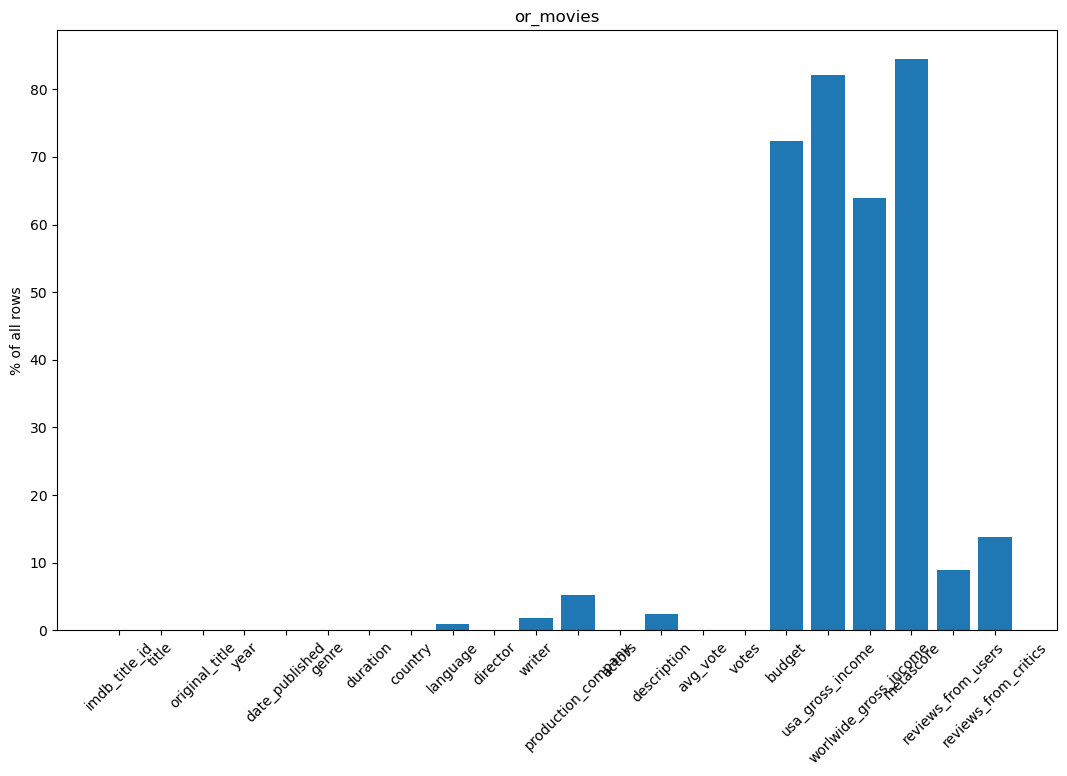

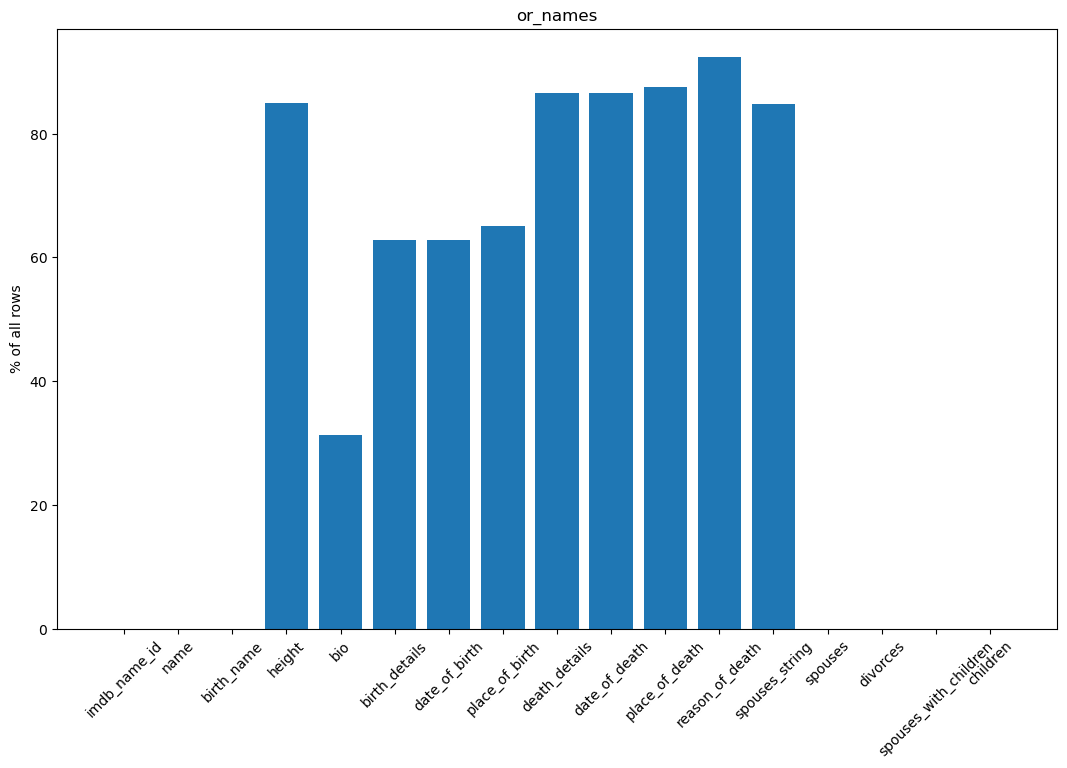

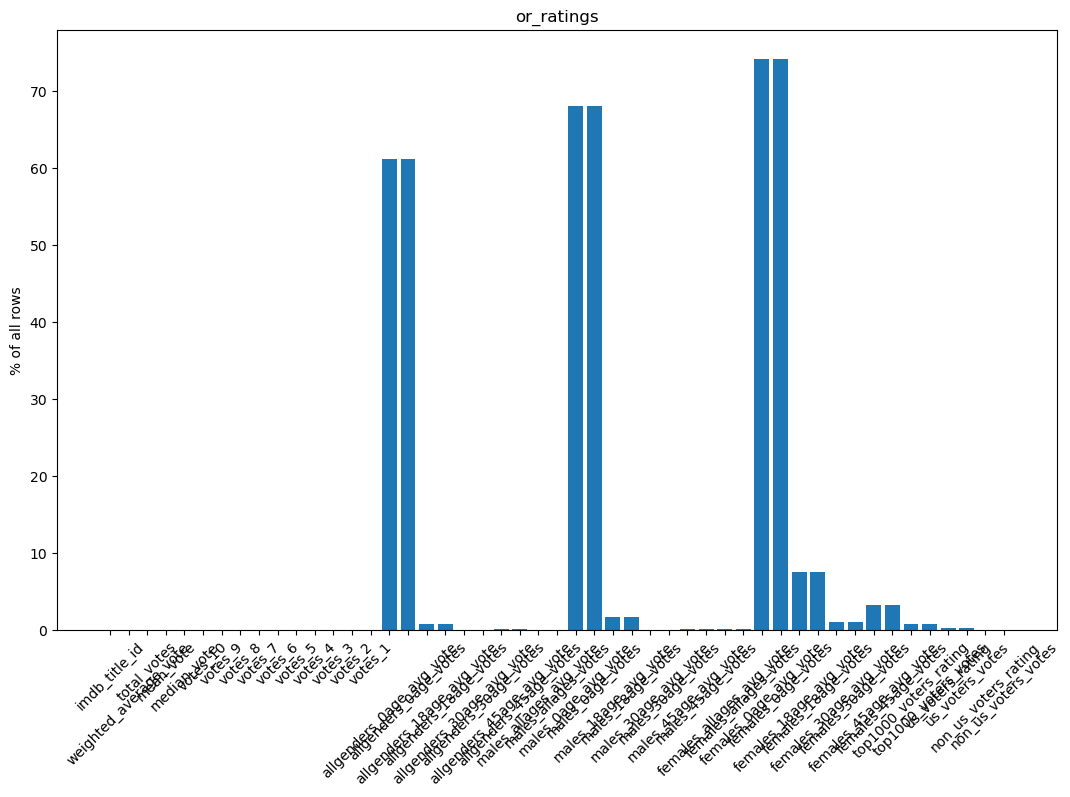

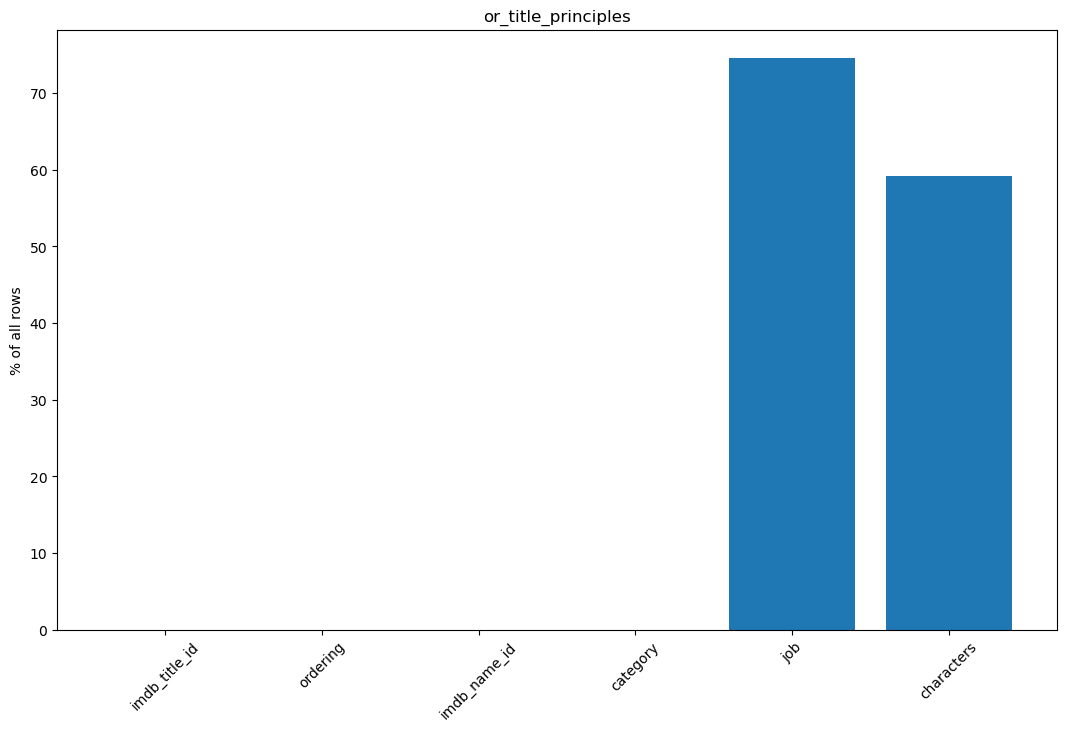

In [5]:
na_counts_movies = or_movies.isna().sum() / len(or_movies) * 100
fig = plt.figure(figsize=(10,6), dpi= 100)
ax = fig.add_axes([0,0,1,1]) # ???
ax.set_title("or_movies")
ax.set_ylabel("% of all rows")
plt.xticks(rotation=45)
ax.bar(or_movies.columns,na_counts_movies)

na_counts_names = or_names.isna().sum() / len(or_names) * 100
fig = plt.figure(figsize=(10,6), dpi= 100)
ax = fig.add_axes([0,0,1,1]) # ???
ax.set_title("or_names")
ax.set_ylabel("% of all rows")
plt.xticks(rotation=45)
ax.bar(or_names.columns,na_counts_names)

na_counts_ratings = or_ratings.isna().sum() / len(or_ratings) * 100
fig = plt.figure(figsize=(10,6), dpi= 100)
ax = fig.add_axes([0,0,1,1]) # ???
ax.set_title("or_ratings")
ax.set_ylabel("% of all rows")
plt.xticks(rotation=45)
ax.bar(or_ratings.columns,na_counts_ratings)

na_counts_title_principles = or_title_principles.isna().sum() / len(or_title_principles) * 100
fig = plt.figure(figsize=(10,6), dpi= 100)
ax = fig.add_axes([0,0,1,1]) # ???
ax.set_title("or_title_principles")
ax.set_ylabel("% of all rows")
plt.xticks(rotation=45)
ax.bar(or_title_principles.columns,na_counts_title_principles)

## 1.3 We will remove columns with more than 50% NA's.|

In [6]:
movie_columns_to_drop = na_counts_movies[na_counts_movies > 50].index
name_columns_to_drop = na_counts_names[na_counts_names > 50].index
ratings_columns_to_drop = na_counts_ratings[na_counts_ratings > 50].index
title_principles_columns_to_drop = na_counts_title_principles[na_counts_title_principles > 50].index

In [7]:
adj_movies = or_movies.drop(columns=movie_columns_to_drop)
adj_name_columns = or_movies.drop(columns=movie_columns_to_drop)
adj_ratings = or_movies.drop(columns=movie_columns_to_drop)
adj_title_principles = or_movies.drop(columns=movie_columns_to_drop)

## 1.4 Now we will clean up the columns

### 1.4.1 remove rows with missing values

First look at ho many missing values therre are per column

In [8]:
for column_name in adj_movies.columns:
    print(column_name, adj_movies[adj_movies[column_name].isna()].shape[0])

imdb_title_id 0
title 0
original_title 0
year 0
date_published 0
genre 0
duration 0
country 64
language 833
director 87
writer 1572
production_company 4455
actors 69
description 2115
avg_vote 0
votes 0
reviews_from_users 7597
reviews_from_critics 11797


Remove rows with missing values for country, director, actors, because these are not much.

In [9]:
before = adj_movies.shape[0]
adj_movies = adj_movies.dropna(subset=[ "country", "director", "actors"])
after = adj_movies.shape[0]
print("rows before:", before, "\nrows after:", after)

rows before: 85855 
rows after: 85656


### 1.4.2 Look for rows that are inconsistent

In [10]:
adj_movies.dtypes

imdb_title_id            object
title                    object
original_title           object
year                     object
date_published           object
genre                    object
duration                  int64
country                  object
language                 object
director                 object
writer                   object
production_company       object
actors                   object
description              object
avg_vote                float64
votes                     int64
reviews_from_users      float64
reviews_from_critics    float64
dtype: object

imdb_title_id is consistant string<br>
title is consistant<br>
original title is consistant<br>
year is not<br>


### 1.4.3 fix year

There is a movie year that is "TV Movie 2019".<br>
So we remove non integers from the strings.<br>
Then we check if there is a string not equal to length 4.<br>
If so we convert them to integers.<br>

In [11]:
test = adj_movies["year"].str.extract('(\d+)', expand=False)
test[test.str.len() != 4]
adj_movies["year"] = test.astype(int)
del test

### 1.4.3 fix date_published

There is a date_published that does not follow the year-month-day format.<br>
We remove that one.

In [12]:
adj_movies[adj_movies["date_published"].str.contains(r'[A-Za-z]')]
adj_movies = adj_movies[~adj_movies["date_published"].str.contains(r'[A-Za-z]')]

How many do not follow the year-month-day format?

In [13]:
before = adj_movies.shape[0]
after = adj_movies[adj_movies["date_published"].str.contains(r'^\d{4}-\d{2}-\d{2}$')].shape[0]
print("incomplete:", before-after, "\npercentage incomplete:", ((before-after) / before)*100)

incomplete: 4541 
percentage incomplete: 5.301500204307979


That is a lot.<br>
But it is only 5% of the data, we can live with that.<br>
We wil remove them.

In [14]:
adj_movies = adj_movies[adj_movies["date_published"].str.contains(r'^\d{4}-\d{2}-\d{2}$')]

We split the year month and day.<br>
We also remove the original column.<br>
missing years, months or days will automatically become None. 

In [15]:
date_published = adj_movies["date_published"].str.split("-", expand=True)
adj_movies["published_year"] = date_published[0].astype(int)
adj_movies["published_month"] = date_published[1].astype(int)
adj_movies["published_day"] = date_published[2].astype(int)

del adj_movies["date_published"]

Lets look if we can replace the year column with date published column.

In [16]:
years_the_same = adj_movies[adj_movies["year"]==date_published[0].astype(int)].shape[0]
all_movies_count = adj_movies.shape[0]
print("# of differences in publish year and year:", all_movies_count-years_the_same)

# of differences in publish year and year: 17034


We can't because they are clearly not the same.

### 1.4.4 fix genre

Lets look at the genre column.

In [17]:
adj_movies["genre"]

0                          Romance
1          Biography, Crime, Drama
2                            Drama
3                   Drama, History
4        Adventure, Drama, Fantasy
                   ...            
85850                       Comedy
85851                Comedy, Drama
85852                        Drama
85853                Drama, Family
85854                        Drama
Name: genre, Length: 81114, dtype: object

Get a list of all genres.

In [18]:
genres = set(",".join(adj_movies["genre"].str.replace(", ", ",").to_list()).split(","))
new_columns = ["genre_"+genre for genre in genres]
new_columns

['genre_Animation',
 'genre_Adult',
 'genre_Crime',
 'genre_Action',
 'genre_Documentary',
 'genre_Comedy',
 'genre_Sci-Fi',
 'genre_Drama',
 'genre_Musical',
 'genre_Sport',
 'genre_Fantasy',
 'genre_Biography',
 'genre_Adventure',
 'genre_Mystery',
 'genre_Music',
 'genre_Romance',
 'genre_Family',
 'genre_Reality-TV',
 'genre_Film-Noir',
 'genre_Western',
 'genre_Thriller',
 'genre_Horror',
 'genre_News',
 'genre_History',
 'genre_War']

<BarContainer object of 25 artists>

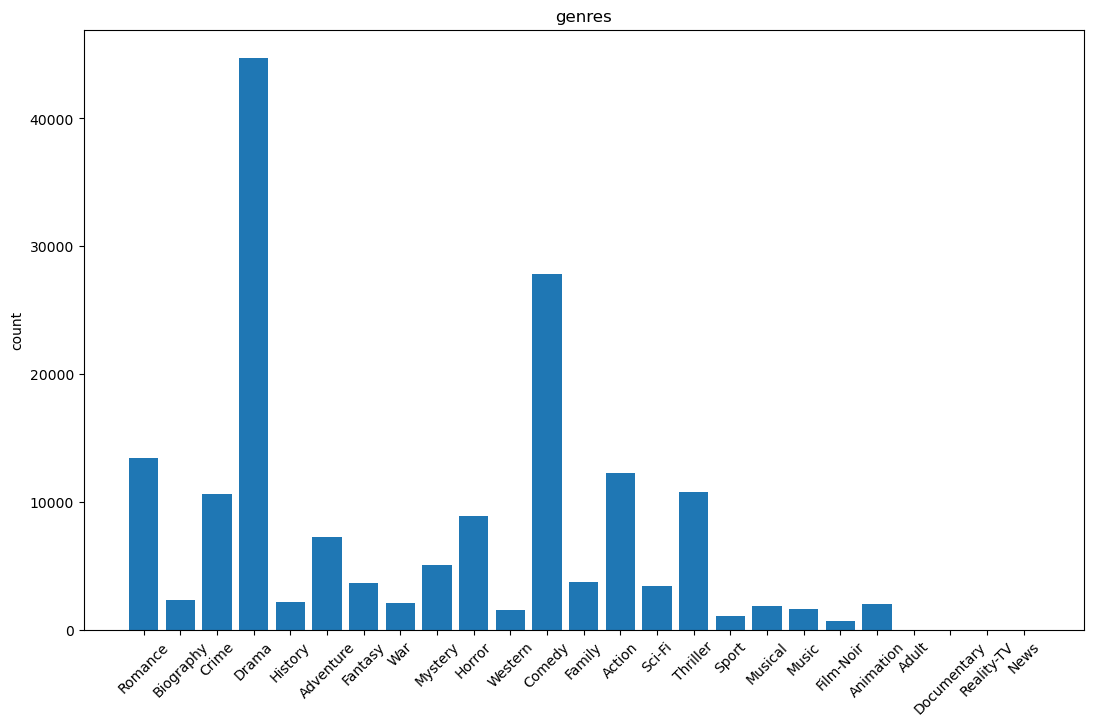

In [19]:
all_genres_raw = ",".join(adj_movies["genre"].str.replace(", ", ",").to_list()).split(",")
# print(len(test), len(set(test)))
counted = Counter(all_genres_raw)
# # all writers
test = pd.DataFrame.from_dict(counted , orient='index').reset_index()
test.rename(columns = {'index':'genre', 0:'count'}, inplace = True)
# test["genre"].to_list()
test

fig = plt.figure(figsize=(10,6), dpi= 100)
ax = fig.add_axes([0,0,1,1]) # ???
ax.set_title("genres")
ax.set_ylabel("count")
plt.xticks(rotation=45)
ax.bar(test["genre"].to_list(),test["count"].to_list())


# genre count
# writers_movie_count = test3.groupby(0).count()
# for_plot.plot(xlabel="writers")
# test.plot(xlabel="genre", ylabel="genre count")

Make columns for those genres.<br>
Loop through genres.<br>
Check if genre is in original list string.<br>

In [20]:
for column_name in new_columns:
    genre = column_name.replace("genre_", "")
    adj_movies[column_name] = adj_movies["genre"].str.contains(genre).astype(int)


    
del adj_movies["genre"]

## 1.5 duration is fine

In [21]:
adj_movies["duration"]

0         45
1         70
2         53
3        100
4         68
        ... 
85850     95
85851    103
85852    130
85853     98
85854     74
Name: duration, Length: 81114, dtype: int64

## 1.6 one_hot_coding for country

In [22]:
adj_movies["country"]

0                     USA
1               Australia
2        Germany, Denmark
3                     USA
4                   Italy
               ...       
85850     France, Belgium
85851         Netherlands
85852               India
85853              Turkey
85854               Spain
Name: country, Length: 81114, dtype: object

In [23]:
countries = set(",".join(adj_movies["country"].str.replace(", ", ",").to_list()).split(","))
new_columns = ["country_"+country for country in countries]
new_columns.sort()

In [24]:
for column_name in new_columns:
    country = column_name.replace("country_", "")
    adj_movies[column_name] = adj_movies["country"].str.contains(country).astype(int)

del adj_movies["country"]

/home/user/ManualInstalls/Anaconda/envs/machinelearning/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


## 1.6 language one-hot coding

In [25]:
adj_movies["language"]

0                 None
1                 None
2                  NaN
3              English
4              Italian
             ...      
85850           French
85851    German, Dutch
85852        Malayalam
85853          Turkish
85854          Catalan
Name: language, Length: 81114, dtype: object

There are cells with more than one langage and cells with nothing.<br>
Then we make a list of unique langages.

In [26]:
# remove NaN
languages = adj_movies[~adj_movies["language"].isnull()]["language"]

# remove None
languages = languages[languages!="None"]

languages = list(set(",".join(languages.str.replace(", ", ",").to_list()).split(",")))

In [27]:
for column_name in languages:
    # very ffing stupid way to do this..
    adj_movies["language_"+column_name] = adj_movies["language"].str.contains(column_name)
    adj_movies["language_"+column_name][adj_movies["language_"+column_name].isnull()] = 0
    adj_movies["language_"+column_name] = adj_movies["language_"+column_name].astype(int)
    
del adj_movies["language"]

<ipython-input-27-f4546155d930>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_movies["language_"+column_name][adj_movies["language_"+column_name].isnull()] = 0


remove languages that occure less than 10 times

In [28]:
adj_movies["language_other"] = 0

for column_name in languages:
    if adj_movies["language_"+column_name].sum() < 10:
        adj_movies[adj_movies["language_"+column_name] == 1]["language_other"] = 1
        # del adj_movies["language_"+column_name]

# adj_movies[adj_movies["language_other"] == 1]
language_columns = ["language_"+language for language in languages]
counted_languages = adj_movies.loc[:,language_columns].sum()
test = pd.DataFrame.from_dict(counted_languages)
test.rename(columns = {'index':'language', 0:'count'}, inplace = True)

<ipython-input-28-5e5e4c1a55e5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_movies[adj_movies["language_"+column_name] == 1]["language_other"] = 1
<ipython-input-28-5e5e4c1a55e5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_movies[adj_movies["language_"+column_name] == 1]["language_other"] = 1
<ipython-input-28-5e5e4c1a55e5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [29]:
columns_to_remove = test[test["count"] < 20].index.to_list()

for column in columns_to_remove:
    adj_movies.loc[adj_movies[column] > 0, "language_other"] = 1
    del adj_movies[column]

## 1.7 director

There will be too many directors.
Just remove the second one??

<AxesSubplot:xlabel='movies count', ylabel='director count'>

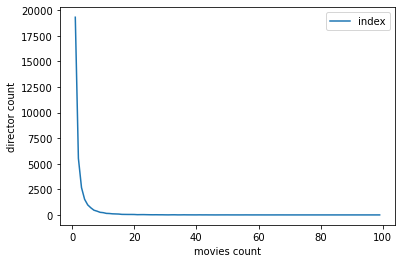

In [30]:
test = adj_movies[~adj_movies["director"].isnull()]


test2 = ",".join(test["director"].str.replace(", ", ",").to_list()).split(",")
# print(len(test), len(set(test)))

# all writers
test3 = pd.DataFrame.from_dict(Counter(test2) , orient='index').reset_index()
# writers count per movie count
writers_movie_count = test3.groupby(0).count()
# for_plot.plot(xlabel="writers")
writers_movie_count.plot(xlabel="movies count", ylabel="director count")

333 directors met meer dan 20 films.<br>
531.815 directors met minder dan 10 films.<br>
33.187 directors totaal......

lets go for top 500 directors

In [39]:
top_500_directors = test3.sort_values(0, ascending=False)[0:500]

def to_list(row):
    try:
        row["director"] = row["director"].split(",")

    except:
        a = 1
    return row


directors = adj_movies.apply(to_list, axis=1)
directors = directors.explode("director")

directors["common_director"] = directors.director.isin(top_500_directors["index"]).astype(int)

common_directors_title_id = directors[directors["common_director"] == 1]["imdb_title_id"]
common_directors_title_id.to_list()

adj_movies["common_director"] = adj_movies["imdb_title_id"].isin(common_directors_title_id.to_list()).astype(int)

In [41]:
del adj_movies["director"]

## 1.8 writer

look at witer counts

<AxesSubplot:xlabel='movies count', ylabel='writers count'>

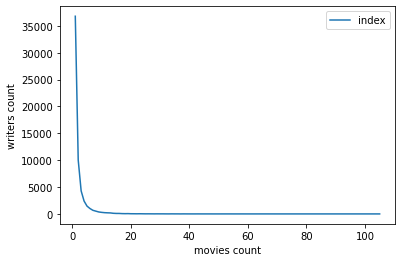

In [42]:
# adj_movies["writer"]

test = adj_movies[~adj_movies["writer"].isnull()]


test2 = ",".join(test["writer"].str.replace(", ", ",").to_list()).split(",")
# print(len(test), len(set(test)))

# all writers
test3 = pd.DataFrame.from_dict(Counter(test2) , orient='index').reset_index()
# writers count per movie count
writers_movie_count = test3.groupby(0).count()
# for_plot.plot(xlabel="writers")
writers_movie_count.plot(xlabel="movies count", ylabel="writers count")

In [43]:
top_250_writers = test3.sort_values(0, ascending=False)[0:250]
# top_250_writers["index"]

def to_list(row):
    try:
        row["writer"] = row["writer"].split(",")

    except:
        a = 1
    return row


writers = adj_movies.apply(to_list, axis=1)
writers = writers.explode("writer")

writers["common_writer"] = writers.writer.isin(top_250_writers["index"]).astype(int)

common_writers_title_id = writers[writers["common_writer"] == 1]["imdb_title_id"]
common_writers_title_id.to_list()

adj_movies["common_writer"] = adj_movies["imdb_title_id"].isin(common_writers_title_id.to_list()).astype(int)

In [44]:
del adj_movies["writer"]

## 1.9 production_company

we need to fill this because there are 4455 missing values.<br>
We do this in the end.

In [45]:
adj_movies["production_company"]

0           Alexander Black Photoplays
1                       J. and N. Tait
2                             Fotorama
3        Helen Gardner Picture Players
4                          Milano Film
                     ...              
85850                Monkey Pack Films
85851             Johan Nijenhuis & Co
85852                 RMCC Productions
85853                      Gizem Ajans
85854    La Xarxa de Comunicació Local
Name: production_company, Length: 81114, dtype: object

## 1.10 top 10 actors

# 2 classificatie

## 2.1 check for class imbalance

we skip this for now

## 2.2 split dataset is test and training

In [ ]:
# taget_column = adj_movies["avg_vote"]
# features = adj_movies.loc[:, adj_movies.columns != 'avg_vote']

# x_train, x_test, y_train, y_test = train_test_split(features, taget_column, test_size=0.2)


In [ ]:
# from sklearn.svm import SVC

# linear = SVC(kernel='linear')
# linear.fit(x_train, y_train)

In [ ]:
int(True)

In [ ]:
adj_movies